Docker image built with [Dockerfile](https://github.com/optimizacion-2-2022-gh-classroom/practica-2-primera-parte-joelitam2021/blob/main/dockerfiles/pkg/Dockerfile)

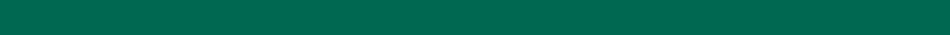

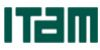

# **Maestría en Ciencia de Datos**
## Temas Selectos de Modelado. Primavera 2022.

### **Equipo 1** 

- Nyrma Paulina Hernández Trejo
- Aide Jazmín González Cruz
- Joel Jaramillo Pacheco
- Jesús Enrique Miranda Blanco

<br>

<div align="center"><h1>Práctica 2</h1></div>


## **Primera parte**

**Descripción:** experimentación, construcción de *pipelines* vía *Minikube, Kubeflow* y *Kale* y reimplementaciones del método numérico realizado en la práctica 1 que resuelva problemas de optimización convexa de pequeña escala. 


El objetivo es realizar experimentos con las herramientas de *Minikube, kubeflow* y *Kale*  para detectar con qué valores no funcionan sus programas. Cambien puntos iniciales, cambien criterios de paro, elijan diferentes ejemplos que los que utilizaron en los *tests* por ejemplo y reimplementen sus métodos que están en su paquete para mejorarlo y robustecerlo. Estos cambios de implementación deben de reflejarse automáticamente vía *Github actions* en la documentación del paquete, *tests* y en sus imágenes de *Docker*.

### **1. Descripción de los parámetros que existen en su problema de optimización y en su método numérico.**

Analizando el problema de optimización que es el *Arbitrage Identification Cycle in Crypto Trading*, donde se busca obtener mayor plusvalía al menor costo en la compra - venta de *bitcoins*, se encontraron los siguientes parámetros:

- **Número de cryptomonedas**: Dependiendo del número de monedas donde se realizará el Arbitrage, la complejidad del algoritmo puede variar.
- **Volumen de transacciones**: Viene de la mano del parámetro anterior, ya que a más número de monedas se tendrán que hacer más operaciones.
- **Tiempo de transacción**: Un parámetro que depende de los parámetros anteriores y el cuál tiene que ser optimizado para que se logre en menor tiempo.

En cuanto al método que se implementó para resolver este problema fue *Bellman Ford*, y se encontraron los siguientes parámetros:

- **Número de vértices**, el cuál depende del grafo dirigido que se da de entrada, nos interesa saber cómo se comporta el algoritmo con un mayor y menor número de nodos.
- **Distancia inicial**: de acuerdo a la bibliografía, se establece que las distancias iniciales para comenzar las relajaciones dentro del método sean de infinito, pero ¿qué pasa si estás distancias son menores?, ¿podría converger más rápido el método?, de esta manera se optimizaría el número de iteraciones y el tiempo que tarda el método en encontrar una solución.
- **Vértice inicial**, se plantea modificar el nodo de inicio desde el cual comienza la comparación entre distancias a los demás nodos, y observar el comportamiento del algoritmo, que al igual que al parámetro anterior se busca optimizar el número de iteraciones y el tiempo que tarda el método en encontrar una solución. Cabe mencionar que en el método implementado en la práctica 1 parte 2 el nodo inicial era el último del gráfo.

Para está práctica se analiza y monitorea en el método los siguientes parámetros:

- **Vertice inicial**
- **Distancia inicial**
        
Los cuales serán medidos a través del tiempo de ejecución y el número de iteraciones (relajaciones) que realiza internamente el método para llegar a una solución.


### **2. Tabla con las corridas con los diferentes parámetros, sus resultados y las fechas de lanzamiento.**

A continuación se realizan corridas con los diferentes parámetros, y la salida es una tabla CSV con los restultados.

In [1]:
from opt2.bellman_ford import bf_negative_cycle
import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt
import time
import pandas as pd
from datetime import datetime

In [4]:
def plot_grapg(grafo, title):
    pos = nx.spring_layout(grafo,k=8)

    nx.draw(grafo, pos, with_labels=True)
    nx.draw_networkx_edge_labels(grafo,
                                 pos,
                                 edge_labels={(u, v): d for u, v, d in grafo.edges(data="weight")},
                                 label_pos=.66)    
    plt.title(title)    
    plt.show()
    
    
def get_data_sol_seg_param(Grafo, node_ini=None, distance_ini=np.inf):
    """
    Recibe un grafo para analizar el comportamiento del método de bellman ford en su procesamiento
    :param: grafo
    :return: tablas reultado y gráficas, y parámetros a comparar
    """
    # Aplicando método Bellman ford modificado para monioreo de parámetros
    start_time = time.time()
    c,lv,p = bf_negative_cycle(Grafo, node_ini, distance_ini)
    time_exec = (time.time() - start_time)
    
    # Minim spanning tree
    print('Creación del Mapa de predecesores que contiene los nodos del mínimo spanning tree: \n\n', p ,'\n\n')
    # Iteraciones, relajación de datos 
    print('Relajaciones, número de iteraciones: ',len(lv))
    # Solución
    print('Solución: ', c)
    # Relajaciones
    arr = np.array(lv)
    m = np.asmatrix(arr)
    print('Relajaciones realizadas: \n\n',m,'\n\n')
    # Separando datos a graficar
    act = np.array(m[:,0])
    ant = np.array(m[:,1])
    ni = map(str, np.array(m[:,2]).flatten().tolist())
    #print(ni)
    nf = map(str, np.array(m[:,3]).flatten().tolist())
    nodes_rel = np.array([','.join(p) for p in zip(ni, nf)])
    #print(nodes_rel)
    
    relajacion_graph(ant,act,nodes_rel)
    relajacion_global(ant,act)
    
    return time_exec

def relajacion_graph(ant,act,nodes_rel):
    """
    Gráfica el comportamiento de las relajaciones
    :param: columnas de las iteraciones de reñajamiento
    :return: gráfica del comportamiento de relajaciones
    """
    
    # Nodos
    x = list(range(1, len(nodes_rel)))
    y2 = act
    y1 = ant

    x = range(100)
    y = range(100,200)
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    ax1.set_title('Relajación de datos')
    ax1.set_xlabel('Edges')
    ax1.set_ylabel('Relajación de datos')

    ax1.scatter(nodes_rel, y1, s=10, c='b', marker="s", label='Valor inicial')
    ax1.scatter(nodes_rel, y2, s=10, c='r', marker="o", label='Valor actualizado')
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks(rotation = 90) 
    plt.show()
    
def relajacion_global(ant,act):
    """
    Gráfica el comportamiento de las relajaciones
    :param: columnas de las iteraciones de reñajamiento
    :return: gráfica del comportamiento de relajaciones
    """
    y2 = act
    y1 = ant
    plt.plot(y1, y2)
 
    # naming the x axis
    plt.xlabel('Valor Inicial')
    # naming the y axis
    plt.ylabel('Valor Actuakizado')

    plt.title('Actualización de datos (relajación global)')

    # function to show the plot
    plt.show() 
    
def compare_complex(x, complejidad, tiempo):
    """
    Gráfica el comportamiento tiempo de ejecución corriendo el método de bellman ford 
    y complejidad de los grafos
    :param: número de nodos del grafo, coplejidad de cada grafo, tiempo de ejecución bellman ford
    :return: gráfica del comportamiento
    """
    print(x)
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    g1, = ax1.plot(x, tiempo)
    ax1.set_ylabel('Tiempo')
    ax1.set_title("Tiempo ejecución Bellman Ford vs Complejidad")
    ax1.set_xlabel('Nodos')

    ax2 = ax1.twinx()  # this is the important function
    g2, = ax2.plot(x, complejidad, 'r')
    ax2.set_xlim([0, np.e])
    ax2.set_ylabel('Complejidad')
    
    plt.legend([g1, g2],["Tiempo", "Complejidad"])
    plt.xticks(range(1, 15))
    plt.xlabel("Número de Nodos", fontsize=12)

    plt.show()

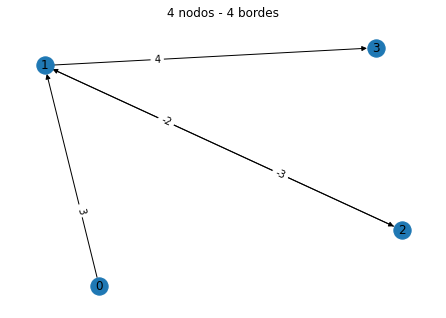

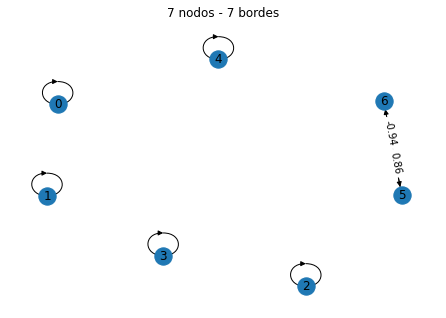

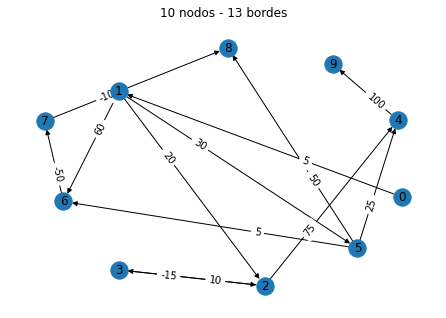

In [3]:
edges1 = [["0","1", 3],
         ["1","2", -2],
         ["2","1", -3],
         ["1","3", 4]]
     
G1 = nx.DiGraph()        
G1.add_weighted_edges_from(edges1)

plot_grapg(G1,'4 nodos - 4 bordes')

edges2 = [["5","6", 0.86],
         ["6","5", -0.94],
         ["3","3",0],
         ["0","0",0],
         ["1","1",0],
         ["2","2",0],
         ["4","4",0]]
        
G2 = nx.DiGraph()        
G2.add_weighted_edges_from(edges2)

plot_grapg(G2,'7 nodos - 7 bordes')

edges3 = [["0","1", 5],
         ["1","2", 20],
         ["1","5", 30],
         ["1","6", 60],
         ["2","3", 10],
         ["2","4", 75],
         ["3","2", -15],
         ["4","9", 100],
         ["5","4", 25],
         ["5","6", 5],
         ["5","8", 50],
         ["6","7", -50],
         ["7","8", -10]]
        
G3 = nx.DiGraph()        
G3.add_weighted_edges_from(edges3)

plot_grapg(G3,'10 nodos - 13 bordes')




 Grafo 1 


Creación del Mapa de predecesores que contiene los nodos del mínimo spanning tree: 

 [ 4.  2.  1.  1. -1.] 


Relajaciones, número de iteraciones:  15
Solución:  [2, 1, 2]
Relajaciones realizadas: 

 [[  0.  inf  -1.   0.]
 [  0.  inf  -1.   1.]
 [  0.  inf  -1.   2.]
 [  0.  inf  -1.   3.]
 [ -2.   0.   4.   2.]
 [ -5.   0.   4.   1.]
 [ -7.  -2.   1.   2.]
 [ -1.   0.   4.   3.]
 [-10.  -5.   2.   1.]
 [-12.  -7.   1.   2.]
 [ -6.  -1.   1.   3.]
 [-15. -10.   2.   1.]
 [-17. -12.   1.   2.]
 [-11.  -6.   1.   3.]
 [-20. -15.   2.   1.]] 




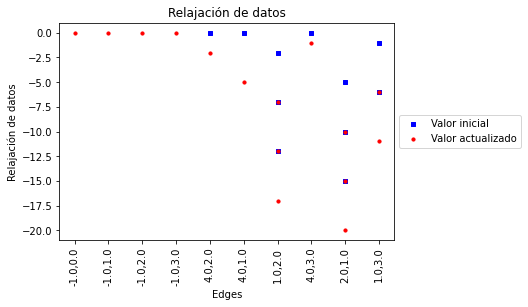

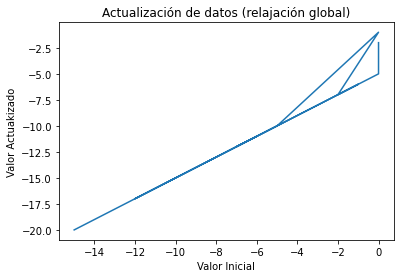




 Grafo 2 


Creación del Mapa de predecesores que contiene los nodos del mínimo spanning tree: 

 [ 7.  7.  7.  7.  7.  6.  5. -1.] 


Relajaciones, número de iteraciones:  20
Solución:  [5, 6, 5]
Relajaciones realizadas: 

 [[ 0.     inf -1.    0.  ]
 [ 0.     inf -1.    1.  ]
 [ 0.     inf -1.    2.  ]
 [ 0.     inf -1.    3.  ]
 [ 0.     inf -1.    4.  ]
 [ 0.     inf -1.    5.  ]
 [ 0.     inf -1.    6.  ]
 [-0.94  0.    7.    5.  ]
 [-0.08  0.    7.    6.  ]
 [-1.02 -0.94  6.    5.  ]
 [-0.16 -0.08  5.    6.  ]
 [-1.1  -1.02  6.    5.  ]
 [-0.24 -0.16  5.    6.  ]
 [-1.18 -1.1   6.    5.  ]
 [-0.32 -0.24  5.    6.  ]
 [-1.26 -1.18  6.    5.  ]
 [-0.4  -0.32  5.    6.  ]
 [-1.34 -1.26  6.    5.  ]
 [-0.48 -0.4   5.    6.  ]
 [-1.42 -1.34  6.    5.  ]] 




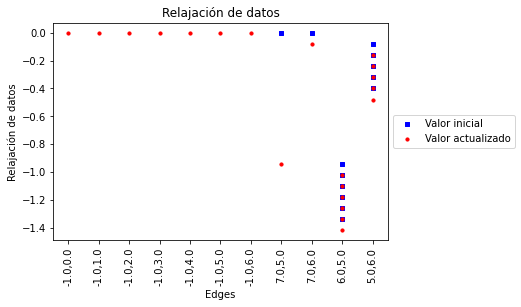

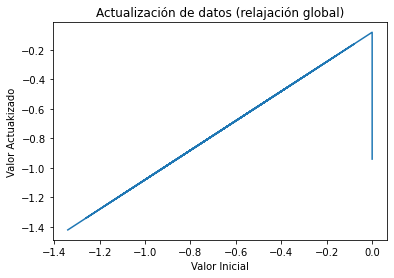




 Grafo 3 


Creación del Mapa de predecesores que contiene los nodos del mínimo spanning tree: 

 [10. 10.  3.  2. 10. 10. 10.  6.  7. 10. -1.] 


Relajaciones, número de iteraciones:  31
Solución:  [3, 2, 3]
Relajaciones realizadas: 

 [[  0.  inf  -1.   0.]
 [  0.  inf  -1.   1.]
 [  0.  inf  -1.   2.]
 [  0.  inf  -1.   3.]
 [  0.  inf  -1.   4.]
 [  0.  inf  -1.   5.]
 [  0.  inf  -1.   6.]
 [  0.  inf  -1.   7.]
 [  0.  inf  -1.   8.]
 [  0.  inf  -1.   9.]
 [-50.   0.  10.   7.]
 [-15.   0.  10.   2.]
 [-60.   0.  10.   8.]
 [ -5.   0.  10.   3.]
 [-20. -15.   3.   2.]
 [-10.  -5.   2.   3.]
 [-25. -20.   3.   2.]
 [-15. -10.   2.   3.]
 [-30. -25.   3.   2.]
 [-20. -15.   2.   3.]
 [-35. -30.   3.   2.]
 [-25. -20.   2.   3.]
 [-40. -35.   3.   2.]
 [-30. -25.   2.   3.]
 [-45. -40.   3.   2.]
 [-35. -30.   2.   3.]
 [-50. -45.   3.   2.]
 [-40. -35.   2.   3.]
 [-55. -50.   3.   2.]
 [-45. -40.   2.   3.]
 [-60. -55.   3.   2.]] 




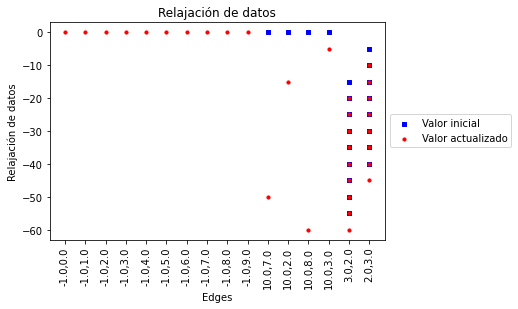

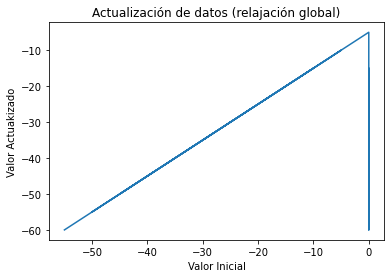

In [5]:
print('\n\n\n Grafo 1 \n\n')
time1 = get_data_sol_seg_param(G1)
print('\n\n\n Grafo 2 \n\n')
time2 = get_data_sol_seg_param(G2)
print('\n\n\n Grafo 3 \n\n')
time3 = get_data_sol_seg_param(G3)

[4, 7, 13]


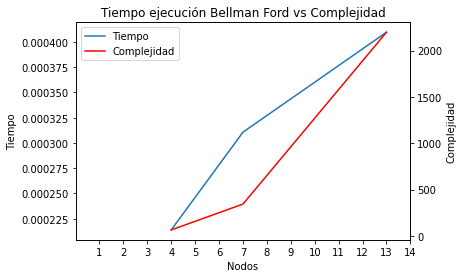

In [6]:
# Se compara el tiempo de ejecución del método de bellman ford y su complejidad de cada grafo, usando en el eje x su número de nodos:
edges_number = np.array([G1.number_of_edges(),G2.number_of_edges(),G3.number_of_edges()])
times =  np.array([time1, time2, time3])
complex_g = np.array([G1.number_of_edges()**3,G2.number_of_edges()**3,G3.number_of_edges()**3])
compare_complex(edges_number.tolist(),complex_g, times)




 Grafo 1 


Variación nodo inicial en nodo 0, Grafo1 


Creación del Mapa de predecesores que contiene los nodos del mínimo spanning tree: 

 [-1.  2.  1.  1. -1.] 


Relajaciones, número de iteraciones:  16
Solución:  [2, 1, 2]
Relajaciones realizadas: 

 [[  3.  inf  -1.   1.]
 [  1.  inf  -1.   2.]
 [  7.  inf  -1.   3.]
 [ -2.   3.   0.   1.]
 [ -4.   1.   1.   2.]
 [  2.   7.   1.   3.]
 [ -7.  -2.   2.   1.]
 [ -9.  -4.   1.   2.]
 [ -3.   2.   1.   3.]
 [-12.  -7.   2.   1.]
 [-14.  -9.   1.   2.]
 [ -8.  -3.   1.   3.]
 [-17. -12.   2.   1.]
 [-19. -14.   1.   2.]
 [-13.  -8.   1.   3.]
 [-22. -17.   2.   1.]] 




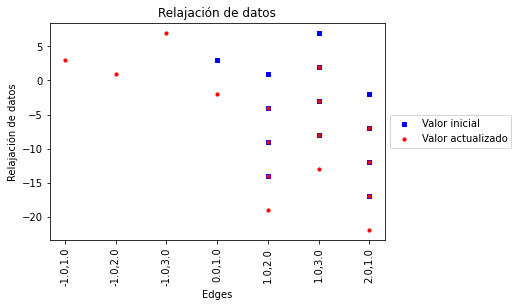

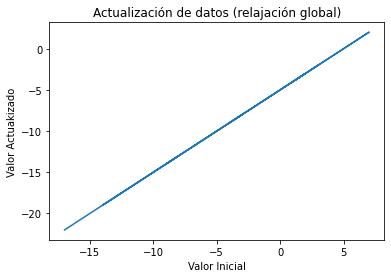



 Variación nodo inicial en nodo 1, Grafo1 


Creación del Mapa de predecesores que contiene los nodos del mínimo spanning tree: 

 [-1.  2.  1.  1. -1.] 


Relajaciones, número de iteraciones:  15
Solución:  [2, 1, 2]
Relajaciones realizadas: 

 [[ -2.  inf  -1.   2.]
 [  4.  inf  -1.   3.]
 [ -5.   0.  -1.   1.]
 [ -7.  -2.   1.   2.]
 [ -1.   4.   1.   3.]
 [-10.  -5.   2.   1.]
 [-12.  -7.   1.   2.]
 [ -6.  -1.   1.   3.]
 [-15. -10.   2.   1.]
 [-17. -12.   1.   2.]
 [-11.  -6.   1.   3.]
 [-20. -15.   2.   1.]
 [-22. -17.   1.   2.]
 [-16. -11.   1.   3.]
 [-25. -20.   2.   1.]] 




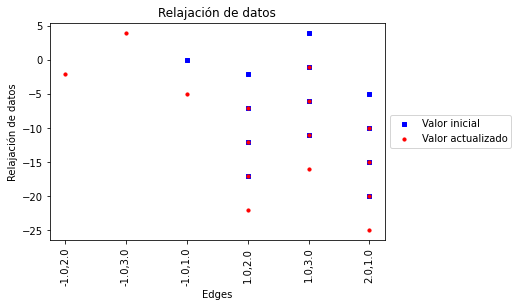

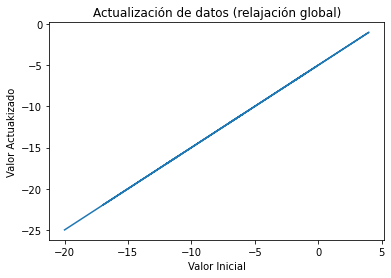



Variación nodo inicial en nodo 2, Grafo1 


Creación del Mapa de predecesores que contiene los nodos del mínimo spanning tree: 

 [-1.  2.  1.  1. -1.] 


Relajaciones, número de iteraciones:  13
Solución:  [2, 1, 2]
Relajaciones realizadas: 

 [[ -3.  inf  -1.   1.]
 [ -5.   0.  -1.   2.]
 [  1.  inf  -1.   3.]
 [ -8.  -3.   2.   1.]
 [-10.  -5.   1.   2.]
 [ -4.   1.   1.   3.]
 [-13.  -8.   2.   1.]
 [-15. -10.   1.   2.]
 [ -9.  -4.   1.   3.]
 [-18. -13.   2.   1.]
 [-20. -15.   1.   2.]
 [-14.  -9.   1.   3.]
 [-23. -18.   2.   1.]] 




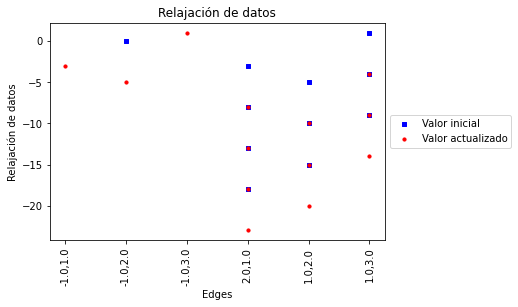

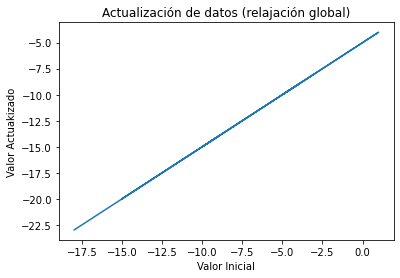

0.09981226921081543

In [7]:
print('\n\n\n Grafo 1 \n\n')
print('Variación nodo inicial en nodo 0, Grafo1 \n\n')
get_data_sol_seg_param(G1,0)

print('\n\n Variación nodo inicial en nodo 1, Grafo1 \n\n')
get_data_sol_seg_param(G1,1)

print('\n\nVariación nodo inicial en nodo 2, Grafo1 \n\n')
get_data_sol_seg_param(G1,2)




 Grafo 2 


Variación nodo inicial en nodo 5, Grafo2 


Creación del Mapa de predecesores que contiene los nodos del mínimo spanning tree: 

 [-1. -1. -1. -1. -1.  6.  5. -1.] 


Relajaciones, número de iteraciones:  16
Solución:  [5, 6, 5]
Relajaciones realizadas: 

 [[ 0.86   inf -1.    6.  ]
 [-0.08  0.   -1.    5.  ]
 [ 0.78  0.86  5.    6.  ]
 [-0.16 -0.08  6.    5.  ]
 [ 0.7   0.78  5.    6.  ]
 [-0.24 -0.16  6.    5.  ]
 [ 0.62  0.7   5.    6.  ]
 [-0.32 -0.24  6.    5.  ]
 [ 0.54  0.62  5.    6.  ]
 [-0.4  -0.32  6.    5.  ]
 [ 0.46  0.54  5.    6.  ]
 [-0.48 -0.4   6.    5.  ]
 [ 0.38  0.46  5.    6.  ]
 [-0.56 -0.48  6.    5.  ]
 [ 0.3   0.38  5.    6.  ]
 [-0.64 -0.56  6.    5.  ]] 




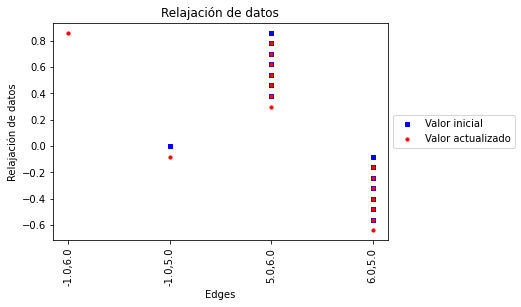

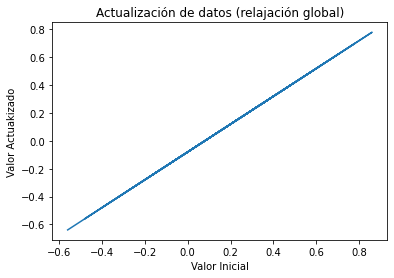



 Variación nodo inicial en nodo 6, Grafo2 


Creación del Mapa de predecesores que contiene los nodos del mínimo spanning tree: 

 [-1. -1. -1. -1. -1.  6.  5. -1.] 


Relajaciones, número de iteraciones:  15
Solución:  [5, 6, 5]
Relajaciones realizadas: 

 [[-0.94   inf -1.    5.  ]
 [-0.08  0.   -1.    6.  ]
 [-1.02 -0.94  6.    5.  ]
 [-0.16 -0.08  5.    6.  ]
 [-1.1  -1.02  6.    5.  ]
 [-0.24 -0.16  5.    6.  ]
 [-1.18 -1.1   6.    5.  ]
 [-0.32 -0.24  5.    6.  ]
 [-1.26 -1.18  6.    5.  ]
 [-0.4  -0.32  5.    6.  ]
 [-1.34 -1.26  6.    5.  ]
 [-0.48 -0.4   5.    6.  ]
 [-1.42 -1.34  6.    5.  ]
 [-0.56 -0.48  5.    6.  ]
 [-1.5  -1.42  6.    5.  ]] 




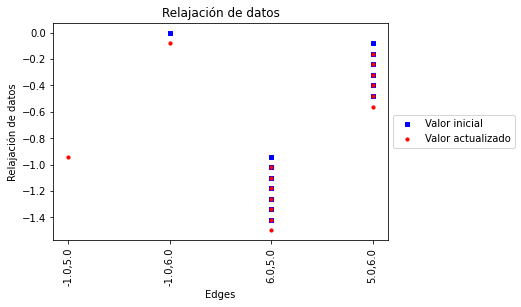

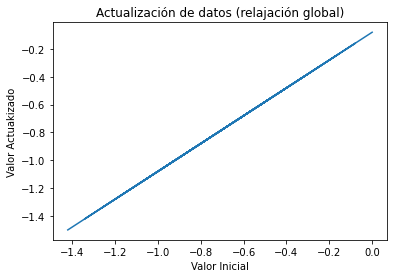

0.00048470497131347656

In [8]:
print('\n\n\n Grafo 2 \n\n')
print('Variación nodo inicial en nodo 5, Grafo2 \n\n')
get_data_sol_seg_param(G2,5)

print('\n\n Variación nodo inicial en nodo 6, Grafo2 \n\n')
get_data_sol_seg_param(G2,6)




 Grafo 3 


Variación nodo inicial en nodo 0, Grafo3 


Creación del Mapa de predecesores que contiene los nodos del mínimo spanning tree: 

 [-1.  0.  3.  2.  2.  1.  5.  6.  7.  4. -1.] 


Relajaciones, número de iteraciones:  37
Solución:  [3, 2, 3]
Relajaciones realizadas: 

 [[  5.  inf  -1.   1.]
 [ 25.  inf  -1.   2.]
 [ 35.  inf  -1.   5.]
 [ 65.  inf  -1.   6.]
 [ 35.  inf  -1.   3.]
 [100.  inf  -1.   4.]
 [ 60. 100.   2.   4.]
 [ 40.  65.   1.   6.]
 [ 85.  inf  -1.   8.]
 [-10.  inf  -1.   7.]
 [ 20.  25.   1.   2.]
 [160.  inf  -1.   9.]
 [-20.  85.   5.   8.]
 [ 30.  35.   2.   3.]
 [ 15.  20.   3.   2.]
 [ 25.  30.   2.   3.]
 [ 10.  15.   3.   2.]
 [ 20.  25.   2.   3.]
 [  5.  10.   3.   2.]
 [ 15.  20.   2.   3.]
 [  0.   5.   3.   2.]
 [ 10.  15.   2.   3.]
 [ -5.   0.   3.   2.]
 [  5.  10.   2.   3.]
 [-10.  -5.   3.   2.]
 [  0.   5.   2.   3.]
 [-15. -10.   3.   2.]
 [ -5.   0.   2.   3.]
 [-20. -15.   3.   2.]
 [-10.  -5.   2.   3.]
 [ 55.  60.   5.   4.]
 [-

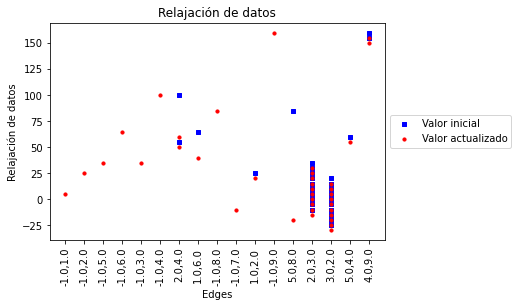

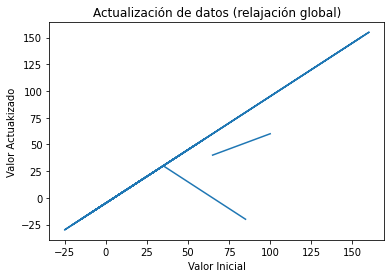



 Variación nodo inicial en nodo 2, Grafo3 


Creación del Mapa de predecesores que contiene los nodos del mínimo spanning tree: 

 [-1. -1.  3.  2.  2. -1. -1. -1. -1.  4. -1.] 


Relajaciones, número de iteraciones:  44
Solución:  [3, 2, 3]
Relajaciones realizadas: 

 [[ 10.  inf  -1.   3.]
 [ 75.  inf  -1.   4.]
 [ -5.   0.  -1.   2.]
 [175.  inf  -1.   9.]
 [  5.  10.   2.   3.]
 [ 70.  75.   2.   4.]
 [-10.  -5.   3.   2.]
 [170. 175.   4.   9.]
 [  0.   5.   2.   3.]
 [ 65.  70.   2.   4.]
 [-15. -10.   3.   2.]
 [165. 170.   4.   9.]
 [ -5.   0.   2.   3.]
 [ 60.  65.   2.   4.]
 [-20. -15.   3.   2.]
 [160. 165.   4.   9.]
 [-10.  -5.   2.   3.]
 [ 55.  60.   2.   4.]
 [-25. -20.   3.   2.]
 [155. 160.   4.   9.]
 [-15. -10.   2.   3.]
 [ 50.  55.   2.   4.]
 [-30. -25.   3.   2.]
 [150. 155.   4.   9.]
 [-20. -15.   2.   3.]
 [ 45.  50.   2.   4.]
 [-35. -30.   3.   2.]
 [145. 150.   4.   9.]
 [-25. -20.   2.   3.]
 [ 40.  45.   2.   4.]
 [-40. -35.   3.   2.]
 [140. 145.   4

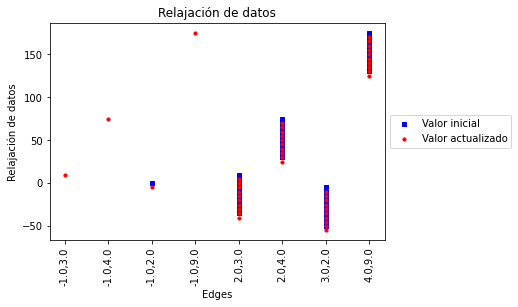

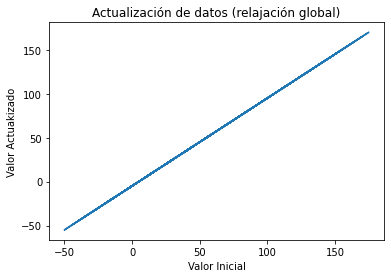



 VVariación nodo inicial en nodo 3, Grafo3 


Creación del Mapa de predecesores que contiene los nodos del mínimo spanning tree: 

 [-1. -1.  3.  2.  2. -1. -1. -1. -1.  4. -1.] 


Relajaciones, número de iteraciones:  41
Solución:  [3, 2, 3]
Relajaciones realizadas: 

 [[-15.  inf  -1.   2.]
 [ -5.   0.  -1.   3.]
 [ 60.  inf  -1.   4.]
 [-20. -15.   3.   2.]
 [160.  inf  -1.   9.]
 [-10.  -5.   2.   3.]
 [ 55.  60.   2.   4.]
 [-25. -20.   3.   2.]
 [155. 160.   4.   9.]
 [-15. -10.   2.   3.]
 [ 50.  55.   2.   4.]
 [-30. -25.   3.   2.]
 [150. 155.   4.   9.]
 [-20. -15.   2.   3.]
 [ 45.  50.   2.   4.]
 [-35. -30.   3.   2.]
 [145. 150.   4.   9.]
 [-25. -20.   2.   3.]
 [ 40.  45.   2.   4.]
 [-40. -35.   3.   2.]
 [140. 145.   4.   9.]
 [-30. -25.   2.   3.]
 [ 35.  40.   2.   4.]
 [-45. -40.   3.   2.]
 [135. 140.   4.   9.]
 [-35. -30.   2.   3.]
 [ 30.  35.   2.   4.]
 [-50. -45.   3.   2.]
 [130. 135.   4.   9.]
 [-40. -35.   2.   3.]
 [ 25.  30.   2.   4.]
 [-55. -50.   

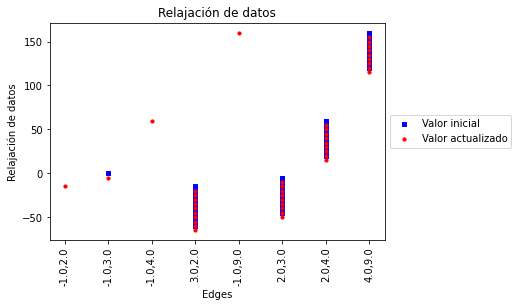

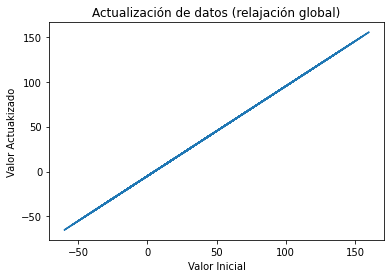

0.0004961490631103516

In [9]:
print('\n\n\n Grafo 3 \n\n')
print('Variación nodo inicial en nodo 0, Grafo3 \n\n')
get_data_sol_seg_param(G3,0)

print('\n\n Variación nodo inicial en nodo 2, Grafo3 \n\n')
get_data_sol_seg_param(G3,2)

print('\n\n VVariación nodo inicial en nodo 3, Grafo3 \n\n')
get_data_sol_seg_param(G3,3)




 Grafo 1 


Variación de Distancia 1, Grafo 1 


Creación del Mapa de predecesores que contiene los nodos del mínimo spanning tree: 

 [ 4.  2.  1.  1. -1.] 


Relajaciones, número de iteraciones:  15
Solución:  [2, 1, 2]
Relajaciones realizadas: 

 [[ -1.   1.  -1.   2.]
 [ -4.   1.  -1.   1.]
 [  0.   1.  -1.   0.]
 [  0.   1.  -1.   3.]
 [ -6.  -1.   1.   2.]
 [ -9.  -4.   2.   1.]
 [-11.  -6.   1.   2.]
 [ -5.   0.   4.   3.]
 [-14.  -9.   2.   1.]
 [-16. -11.   1.   2.]
 [-10.  -5.   1.   3.]
 [-19. -14.   2.   1.]
 [-21. -16.   1.   2.]
 [-15. -10.   1.   3.]
 [-24. -19.   2.   1.]] 




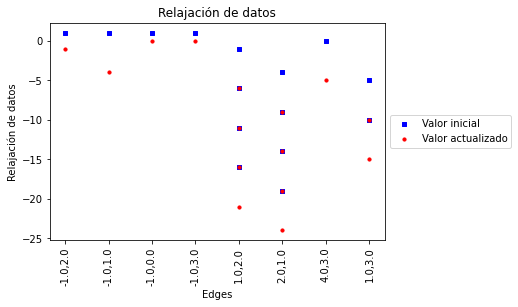

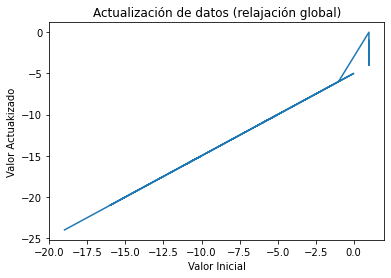



 Variación de Distancia 100, Grafo 1 


Creación del Mapa de predecesores que contiene los nodos del mínimo spanning tree: 

 [ 4.  2.  1.  1. -1.] 


Relajaciones, número de iteraciones:  17
Solución:  [2, 1, 2]
Relajaciones realizadas: 

 [[ 98. 100.  -1.   2.]
 [ 95. 100.  -1.   1.]
 [  0. 100.  -1.   0.]
 [  0.  95.   2.   1.]
 [  0.  98.   1.   2.]
 [  0. 100.  -1.   3.]
 [ -2.   0.   4.   2.]
 [ -5.   0.   4.   1.]
 [ -7.  -2.   1.   2.]
 [ -1.   0.   4.   3.]
 [-10.  -5.   2.   1.]
 [-12.  -7.   1.   2.]
 [ -6.  -1.   1.   3.]
 [-15. -10.   2.   1.]
 [-17. -12.   1.   2.]
 [-11.  -6.   1.   3.]
 [-20. -15.   2.   1.]] 




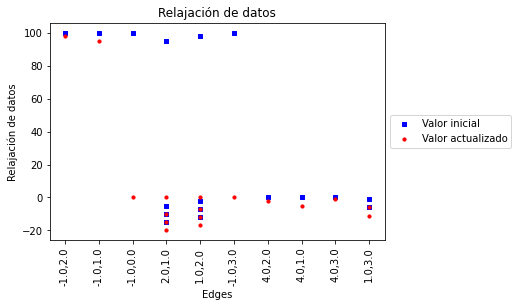

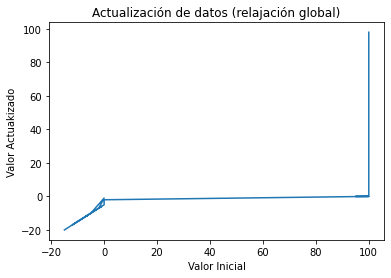



 Variación de Distancia 1000, Grafo 1 


Creación del Mapa de predecesores que contiene los nodos del mínimo spanning tree: 

 [ 4.  2.  1.  1. -1.] 


Relajaciones, número de iteraciones:  17
Solución:  [2, 1, 2]
Relajaciones realizadas: 

 [[ 998. 1000.   -1.    2.]
 [ 995. 1000.   -1.    1.]
 [   0. 1000.   -1.    0.]
 [   0.  995.    2.    1.]
 [   0.  998.    1.    2.]
 [   0. 1000.   -1.    3.]
 [  -2.    0.    4.    2.]
 [  -5.    0.    4.    1.]
 [  -7.   -2.    1.    2.]
 [  -1.    0.    4.    3.]
 [ -10.   -5.    2.    1.]
 [ -12.   -7.    1.    2.]
 [  -6.   -1.    1.    3.]
 [ -15.  -10.    2.    1.]
 [ -17.  -12.    1.    2.]
 [ -11.   -6.    1.    3.]
 [ -20.  -15.    2.    1.]] 




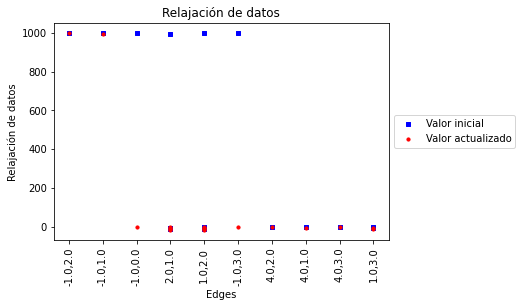

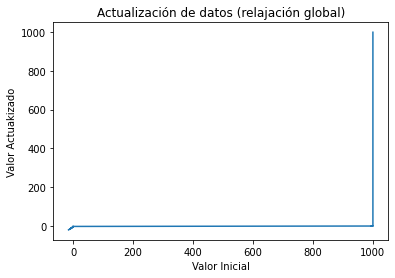

0.0950164794921875

In [10]:
print('\n\n\n Grafo 1 \n\n')
print('Variación de Distancia 1, Grafo 1 \n\n')
get_data_sol_seg_param(G1,None,1)

print('\n\n Variación de Distancia 100, Grafo 1 \n\n')
get_data_sol_seg_param(G1,None,100)

print('\n\n Variación de Distancia 1000, Grafo 1 \n\n')
get_data_sol_seg_param(G1,None,1000)




 Grafo 2 


Variación de Distancia 1, Grafo 2 


Creación del Mapa de predecesores que contiene los nodos del mínimo spanning tree: 

 [ 7.  7.  7.  7.  7.  6.  5. -1.] 


Relajaciones, número de iteraciones:  21
Solución:  [5, 6, 5]
Relajaciones realizadas: 

 [[ 0.06  1.   -1.    5.  ]
 [ 0.    1.   -1.    0.  ]
 [ 0.    1.   -1.    1.  ]
 [ 0.    1.   -1.    2.  ]
 [ 0.    1.   -1.    3.  ]
 [ 0.    1.   -1.    4.  ]
 [ 0.    0.06  6.    5.  ]
 [ 0.    1.   -1.    6.  ]
 [-0.94  0.    7.    5.  ]
 [-0.08  0.    7.    6.  ]
 [-1.02 -0.94  6.    5.  ]
 [-0.16 -0.08  5.    6.  ]
 [-1.1  -1.02  6.    5.  ]
 [-0.24 -0.16  5.    6.  ]
 [-1.18 -1.1   6.    5.  ]
 [-0.32 -0.24  5.    6.  ]
 [-1.26 -1.18  6.    5.  ]
 [-0.4  -0.32  5.    6.  ]
 [-1.34 -1.26  6.    5.  ]
 [-0.48 -0.4   5.    6.  ]
 [-1.42 -1.34  6.    5.  ]] 




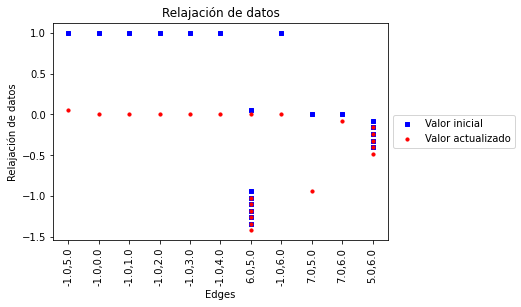

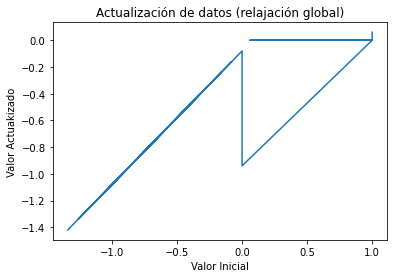



 Variación de Distancia 100, Grafo 2 


Creación del Mapa de predecesores que contiene los nodos del mínimo spanning tree: 

 [ 7.  7.  7.  7.  7.  6.  5. -1.] 


Relajaciones, número de iteraciones:  21
Solución:  [5, 6, 5]
Relajaciones realizadas: 

 [[ 9.906e+01  1.000e+02 -1.000e+00  5.000e+00]
 [ 0.000e+00  1.000e+02 -1.000e+00  0.000e+00]
 [ 0.000e+00  1.000e+02 -1.000e+00  1.000e+00]
 [ 0.000e+00  1.000e+02 -1.000e+00  2.000e+00]
 [ 0.000e+00  1.000e+02 -1.000e+00  3.000e+00]
 [ 0.000e+00  1.000e+02 -1.000e+00  4.000e+00]
 [ 0.000e+00  9.906e+01  6.000e+00  5.000e+00]
 [ 0.000e+00  1.000e+02 -1.000e+00  6.000e+00]
 [-9.400e-01  0.000e+00  7.000e+00  5.000e+00]
 [-8.000e-02  0.000e+00  7.000e+00  6.000e+00]
 [-1.020e+00 -9.400e-01  6.000e+00  5.000e+00]
 [-1.600e-01 -8.000e-02  5.000e+00  6.000e+00]
 [-1.100e+00 -1.020e+00  6.000e+00  5.000e+00]
 [-2.400e-01 -1.600e-01  5.000e+00  6.000e+00]
 [-1.180e+00 -1.100e+00  6.000e+00  5.000e+00]
 [-3.200e-01 -2.400e-01  5.000e+00  6.00

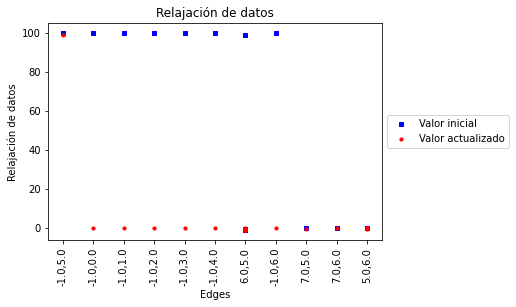

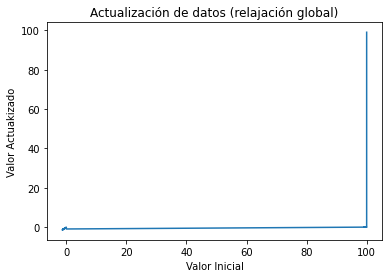



 Variación de Distancia 1000, Grafo 2 


Creación del Mapa de predecesores que contiene los nodos del mínimo spanning tree: 

 [ 7.  7.  7.  7.  7.  6.  5. -1.] 


Relajaciones, número de iteraciones:  21
Solución:  [5, 6, 5]
Relajaciones realizadas: 

 [[ 9.9906e+02  1.0000e+03 -1.0000e+00  5.0000e+00]
 [ 0.0000e+00  1.0000e+03 -1.0000e+00  0.0000e+00]
 [ 0.0000e+00  1.0000e+03 -1.0000e+00  1.0000e+00]
 [ 0.0000e+00  1.0000e+03 -1.0000e+00  2.0000e+00]
 [ 0.0000e+00  1.0000e+03 -1.0000e+00  3.0000e+00]
 [ 0.0000e+00  1.0000e+03 -1.0000e+00  4.0000e+00]
 [ 0.0000e+00  9.9906e+02  6.0000e+00  5.0000e+00]
 [ 0.0000e+00  1.0000e+03 -1.0000e+00  6.0000e+00]
 [-9.4000e-01  0.0000e+00  7.0000e+00  5.0000e+00]
 [-8.0000e-02  0.0000e+00  7.0000e+00  6.0000e+00]
 [-1.0200e+00 -9.4000e-01  6.0000e+00  5.0000e+00]
 [-1.6000e-01 -8.0000e-02  5.0000e+00  6.0000e+00]
 [-1.1000e+00 -1.0200e+00  6.0000e+00  5.0000e+00]
 [-2.4000e-01 -1.6000e-01  5.0000e+00  6.0000e+00]
 [-1.1800e+00 -1.1000e+00  6.0

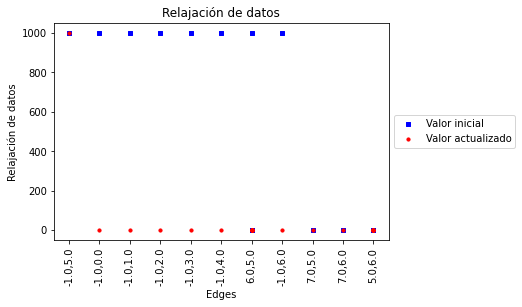

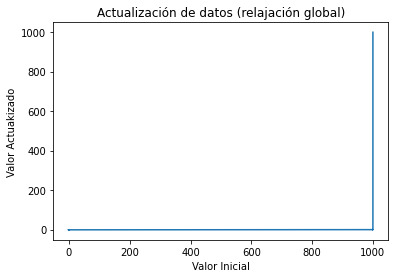

0.0002696514129638672

In [11]:
print('\n\n\n Grafo 2 \n\n')
print('Variación de Distancia 1, Grafo 2 \n\n')
get_data_sol_seg_param(G2,None,1)

print('\n\n Variación de Distancia 100, Grafo 2 \n\n')
get_data_sol_seg_param(G2,None,100)

print('\n\n Variación de Distancia 1000, Grafo 2 \n\n')
get_data_sol_seg_param(G2,None,1000)




 Grafo 3 


Variación de Distancia 1, Grafo 3 


Creación del Mapa de predecesores que contiene los nodos del mínimo spanning tree: 

 [10. 10.  3.  2. 10. 10. 10.  6.  7. 10. -1.] 


Relajaciones, número de iteraciones:  32
Solución:  [3, 2, 3]
Relajaciones realizadas: 

 [[-49.   1.  -1.   7.]
 [-14.   1.  -1.   2.]
 [-59.   1.  -1.   8.]
 [  0.   1.  -1.   0.]
 [  0.   1.  -1.   1.]
 [  0.   1.  -1.   3.]
 [  0.   1.  -1.   4.]
 [  0.   1.  -1.   5.]
 [  0.   1.  -1.   6.]
 [  0.   1.  -1.   9.]
 [ -4.   0.  10.   3.]
 [-50. -49.   6.   7.]
 [-19. -14.   3.   2.]
 [-60. -59.   7.   8.]
 [ -9.  -4.   2.   3.]
 [-24. -19.   3.   2.]
 [-14.  -9.   2.   3.]
 [-29. -24.   3.   2.]
 [-19. -14.   2.   3.]
 [-34. -29.   3.   2.]
 [-24. -19.   2.   3.]
 [-39. -34.   3.   2.]
 [-29. -24.   2.   3.]
 [-44. -39.   3.   2.]
 [-34. -29.   2.   3.]
 [-49. -44.   3.   2.]
 [-39. -34.   2.   3.]
 [-54. -49.   3.   2.]
 [-44. -39.   2.   3.]
 [-59. -54.   3.   2.]
 [-49. -44.   2.   3.]
 [-64. -59

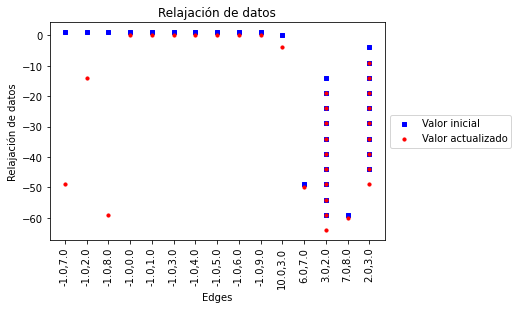

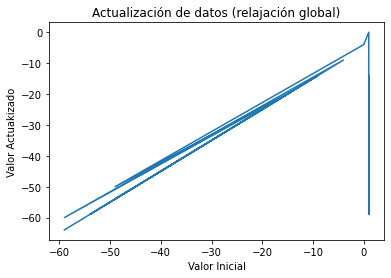



 Variación de Distancia 100, Grafo 3 


Creación del Mapa de predecesores que contiene los nodos del mínimo spanning tree: 

 [10. 10.  3.  2. 10. 10. 10.  6.  7. 10. -1.] 


Relajaciones, número de iteraciones:  34
Solución:  [3, 2, 3]
Relajaciones realizadas: 

 [[ 50. 100.  -1.   7.]
 [ 85. 100.  -1.   2.]
 [ 40. 100.  -1.   8.]
 [  0. 100.  -1.   0.]
 [  0. 100.  -1.   1.]
 [  0.  85.   3.   2.]
 [  0. 100.  -1.   3.]
 [  0. 100.  -1.   4.]
 [  0. 100.  -1.   5.]
 [  0. 100.  -1.   6.]
 [  0.  50.   6.   7.]
 [  0.  40.   7.   8.]
 [  0. 100.  -1.   9.]
 [-50.   0.  10.   7.]
 [-15.   0.  10.   2.]
 [-60.   0.  10.   8.]
 [ -5.   0.  10.   3.]
 [-20. -15.   3.   2.]
 [-10.  -5.   2.   3.]
 [-25. -20.   3.   2.]
 [-15. -10.   2.   3.]
 [-30. -25.   3.   2.]
 [-20. -15.   2.   3.]
 [-35. -30.   3.   2.]
 [-25. -20.   2.   3.]
 [-40. -35.   3.   2.]
 [-30. -25.   2.   3.]
 [-45. -40.   3.   2.]
 [-35. -30.   2.   3.]
 [-50. -45.   3.   2.]
 [-40. -35.   2.   3.]
 [-55. -50.   3.   2

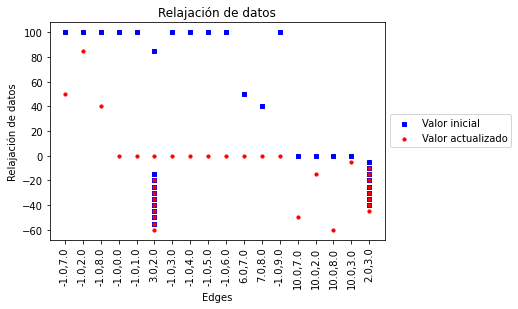

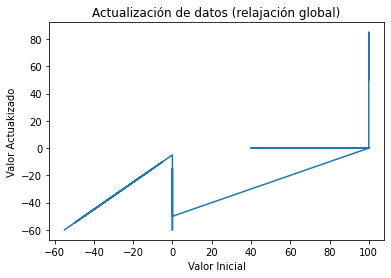



 Variación de Distancia 1000, Grafo 3 


Creación del Mapa de predecesores que contiene los nodos del mínimo spanning tree: 

 [10. 10.  3.  2. 10. 10. 10.  6.  7. 10. -1.] 


Relajaciones, número de iteraciones:  34
Solución:  [3, 2, 3]
Relajaciones realizadas: 

 [[ 950. 1000.   -1.    7.]
 [ 985. 1000.   -1.    2.]
 [ 940. 1000.   -1.    8.]
 [   0. 1000.   -1.    0.]
 [   0. 1000.   -1.    1.]
 [   0.  985.    3.    2.]
 [   0. 1000.   -1.    3.]
 [   0. 1000.   -1.    4.]
 [   0. 1000.   -1.    5.]
 [   0. 1000.   -1.    6.]
 [   0.  950.    6.    7.]
 [   0.  940.    7.    8.]
 [   0. 1000.   -1.    9.]
 [ -50.    0.   10.    7.]
 [ -15.    0.   10.    2.]
 [ -60.    0.   10.    8.]
 [  -5.    0.   10.    3.]
 [ -20.  -15.    3.    2.]
 [ -10.   -5.    2.    3.]
 [ -25.  -20.    3.    2.]
 [ -15.  -10.    2.    3.]
 [ -30.  -25.    3.    2.]
 [ -20.  -15.    2.    3.]
 [ -35.  -30.    3.    2.]
 [ -25.  -20.    2.    3.]
 [ -40.  -35.    3.    2.]
 [ -30.  -25.    2.    3.]
 [ 

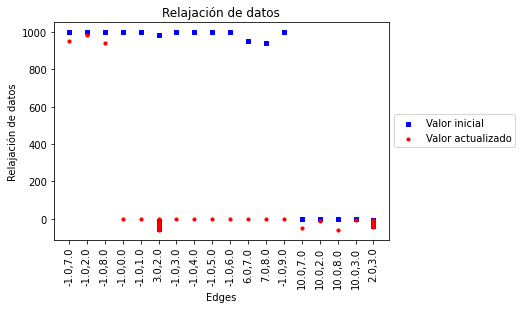

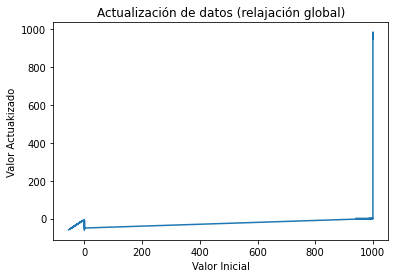

0.001180887222290039

In [12]:
print('\n\n\n Grafo 3 \n\n')
print('Variación de Distancia 1, Grafo 3 \n\n')
get_data_sol_seg_param(G3,None,1)

print('\n\n Variación de Distancia 100, Grafo 3 \n\n')
get_data_sol_seg_param(G3,None,100)

print('\n\n Variación de Distancia 1000, Grafo 3 \n\n')
get_data_sol_seg_param(G3,None,1000)

In [13]:
graphs = dict({1:G1,2:G2,3:G3})
distances = [1,5,10,20,50,100]

In [14]:
aux = pd.DataFrame()
times = []
iters = []
nod = []
dist = []
g = []
sol = []
for graph in graphs.items():
    nodes = list(map(int,list(graph[1].nodes)))
    for node in nodes:
        for distance in distances:
            # Aplicando método Bellman ford modificado para monioreo de parámetros
            start_time = time.time()
            c,lv,p = bf_negative_cycle(graph[1], node, distance)
            time_exec = (time.time() - start_time)
            times.append(time_exec)
            iters.append(len(lv))
            dist.append(distance)
            sol.append(c)
        nod += len(distances) * [node]
    g += (len(distances) * len(nodes)) * [graph[0]]
aux['distance'] = pd.Series(dist)
aux['node'] = pd.Series(nod)
aux['time'] = pd.Series(times)
aux['iter'] = pd.Series(iters)
aux['graph'] = pd.Series(g)
aux['sol'] = pd.Series(sol)
aux['date'] = datetime.today().strftime('%Y-%m-%d %H:%M')
aux[['graph','node','sol','distance','iter','time','date']]

,graph,node,sol,distance,iter,time,date
0,1,0,"[2, 1, 2]",1,14,0.000303,2022-04-23 18:43
1,1,0,"[2, 1, 2]",5,15,0.296266,2022-04-23 18:43
2,1,0,"[2, 1, 2]",10,16,0.000269,2022-04-23 18:43
3,1,0,"[2, 1, 2]",20,16,0.000169,2022-04-23 18:43
4,1,0,"[2, 1, 2]",50,16,0.000164,2022-04-23 18:43
...,...,...,...,...,...,...,...
121,3,7,"[3, 2, 3]",5,23,0.000382,2022-04-23 18:43
122,3,7,"[3, 2, 3]",10,23,0.000345,2022-04-23 18:43
123,3,7,"[3, 2, 3]",20,23,0.000326,2022-04-23 18:43
124,3,7,"[3, 2, 3]",50,22,0.000682,2022-04-23 18:43


In [ ]:
aux[['graph','node','sol','distance','iter','time','date']].to_csv('tabla_reporte.csv',index=False)

### **Referencias:**

**<sup>(1)</sup>** [Bellman-Ford Algorithm](https://www.sciencedirect.com/topics/computer-science/bellman-ford-algorithm).

**<sup>(2)</sup>** [bellman_ford_shortest_paths](https://www.boost.org/doc/libs/1_62_0/libs/graph/doc/bellman_ford_shortest.html)

**<sup>(3)</sup>** [An Analysis of Bellman-Ford and Dijkstra’s Algorithm](https://melitadsouza.github.io/pdf/algos.pdf)

**<sup>(4)</sup>** [6.Minikube y AWS](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/wiki/6.Minikube-y-AWS)

**<sup>(5)</sup>** [Minikube, Kubeflow y Kale 2022](https://www.youtube.com/watch?v=SusT5xQN1ro)